In [1]:
%matplotlib inline
import csv
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pylab import hist2d

In [2]:
#http://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
import matplotlib as mpl
cmapp = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['blue','red'],256)
cmapp._init()
alphas = np.linspace(0, 0.8, cmapp.N+3)
cmapp._lut[:,-1] = alphas

In [3]:
#http://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
def datetime_range(start=None, end=None):
    span = end - start
    for i in xrange(span.days + 1):
        yield start + datetime.timedelta(days=i)

In [4]:
# dear god, how i wish i'd used pandas

hr_bin = 3.0;

datX = []
datL = []
with open('input/crimes.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for dat in reader:
        try:
            tim = datetime.datetime.strptime(dat[2], "%m/%d/%Y %I:%M:%S %p")
            lat = float(dat[19])
            lng = float(dat[20])
            datX.append([lat,lng,tim.hour,tim.weekday(),tim.month,tim.year])
            datL.append([dat[5],dat[7]])
        except:
            pass
X = np.array(datX);
L = np.array(datL);

In [6]:
L[np.char.find(L[:,1],'AIR')>=0,1]='AIRPORT'
L[np.char.find(L[:,0],'NON')>=0,0]='NON-CRIMINAL'
L[np.char.find(L[:,1],'CTA')>=0,1]='CTA'

keep = np.logical_or(np.char.find(L[:,1],'STREET')>=0,np.logical_or(np.char.find(L[:,1],'SIDEWALK')>=0,np.logical_or(L[:,1]=='OTHER',np.logical_or(np.char.find(L[:,1],'LOT/GARAGE')>=0,np.logical_or(L[:,1]=='ALLEY',np.char.find(L[:,1],'CTA')>=0)))))
keep = np.logical_and(keep, np.logical_not(np.logical_or(np.char.find(L[:,0],'ARSON')>=0,np.logical_or(np.char.find(L[:,0],'CARRY')>=0,np.logical_or(np.char.find(L[:,0],'HUMAN')>=0,np.logical_or(np.char.find(L[:,0],'INDECENCY')>=0,np.logical_or(np.char.find(L[:,0],'LIQUOR')>=0,np.logical_or(np.char.find(L[:,0],'GAMBLING')>=0,np.logical_or(np.char.find(L[:,0],'PROSTITUTION')>=0,np.logical_or(np.char.find(L[:,0],'STALKING')>=0,np.logical_or(np.char.find(L[:,0],'KIDNAPPING')>=0,np.logical_or(np.char.find(L[:,0],'INTIMIDATION')>=0,np.logical_or(np.char.find(L[:,0],'OBSCENITY')>=0,np.char.find(L[:,0],'NARCOTICS')>=0)))))))))))))
keep = np.logical_and(keep,np.logical_and(X[:,1]>-87.9,X[:,5]<2015))
L=L[keep,:]
X=X[keep,:]

In [7]:
H, yedges, xedges = np.histogram2d(X[:,0], X[:,1], bins=80)

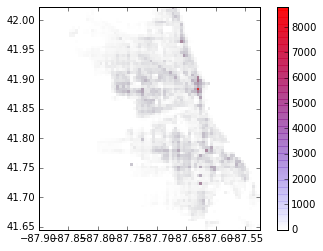

In [8]:
plt.imshow(H,cmap=cmapp,interpolation='none',origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar();

In [9]:
fX = X
from scipy import interpolate
f_x = interpolate.interp1d(xedges, xedges,kind='nearest')
fX[:,1] = f_x(fX[:,1])

f_y = interpolate.interp1d(yedges, yedges,kind='nearest')
fX[:,0] = f_y(fX[:,0])

fX[:,2]=np.floor(fX[:,2]/hr_bin)*hr_bin

In [10]:
mak = {}
for row in fX:
    v = tuple(row)
    if(v in mak):
        mak[v]=mak[v]+1
    else:
        mak[v]=1.
makk = np.vstack(mak.items())
binX = np.vstack(makk[:,0])
binY = np.vstack(makk[:,1])

In [11]:
cntT = {}
for tim in datetime_range(datetime.datetime(2001, 1, 1),datetime.datetime(2014, 1, 1)):
    tup = (tim.weekday(),tim.month)
    if(tup in cntT):
        cntT[tup]=cntT[tup]+1
    else:
        cntT[tup]=1.

In [12]:
for i in range(binY.shape[0]):
    n=cntT[(binX[i,3],binX[i,4])]
    binY[i]=float(binY[i])/n/hr_bin

In [ ]:
#this is sooo clunky and stupid, but can't figure better way to convert np.arrays into dicts
import json
for h in set(binX[:,2]):
    for d in set(binX[:,3]):
        for m in set(binX[:,4]):
            dic = {'latS':yedges[0],'lonW':xedges[1],'dlat':yedges[1]-yedges[0],'dlon':xedges[1]-xedges[0]}
            ind1 = np.logical_and(binX[:,2]==h,np.logical_and(binX[:,3]==d,binX[:,4]==m))
            for (lat,lon) in set(tuple(map(tuple, binX[ind1,:2]))):
                la = int(round((lat-dic['latS'])/dic['dlat']))
                lo = int(round((lon-dic['lonW'])/dic['dlon']))
                if la not in dic:
                    dic[la]={}
                inds = np.logical_and(ind1,np.logical_and(binX[:,0]==lat,binX[:,1]==lon))
                dic[la][lo]={'avg':np.sum(binY[inds])/14.,'max':np.max(binY[inds])}
            nm = 'output/dataM%02dD%02dH%02d.json' % (m,d,h)
            with open(nm, 'w') as outfile:
                json.dump(dic, outfile)

In [ ]:
dic